# <font size="10"><p style="text-align: center;color:#2a4b8d">A short guide on where to safely eat delicious food in Chicago</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import seaborn as sns
import os, sys
import re
from datetime import datetime, date, time
import json
from shapely.geometry import shape, Point
from area import area
import folium
from folium.plugins import TimestampedGeoJson
from pathlib import Path
from difflib import get_close_matches

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# <p style="color:#2e86c1">Data collection

## Chicago Food Inspections (CFI) dataset

This is our main [dataset](https://www.kaggle.com/chicago/chicago-food-inspections), where the information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. This dataset contains 22 columns and as of October 23, 2019 there are 194’784 entries (updated frequently, so subject to change). 

In [75]:
cfi = pd.read_csv('data/food-inspections.csv')
print('There are {0} samples and {1} columns in the dataset'.format(cfi.shape[0],cfi.shape[1]))

There are 194784 samples and 22 columns in the dataset


## Yelp Reviews (YR) dataset

Yelp.com is a website that helps people find great local businesses such as restaurants based on customer reviews. Each business has a page where visitors can write comments and add a general grade reflecting their experience there. The [Yelp fusion API](https://www.yelp.com/developers/documentation/v3/business_search) enables us to access relevant information on restaurants such as their rating and their respective number of reviews. When trying to scrap the data, we first encountered an issue of how to uniquely identify each restaurant. Indeed, the Yelp API enables us to pass as an argument the latitude and longitude of all places we want to query. We initially thought that this will enable us to find the right businesses. However, the Yelp coordinates do not match exactly the ones of our dataset. Thus, quering by latitude/longitude didn't give us the right business (we generally obtained restaurants, which were closed to the one in which we were interested).

Therefore, we had to come up with another way to query our dataset. By looking at the API documentation on Yelp Fusion website, we found another function, called `business_match_query`, which enables us to give as argument the name and complete address of every restaurant. Trying this function on a few cases showed us that by doing this "cross-research", taking into account several pieces of information on the businesses, we obtain the right results. However, one disadvantage of this function is that the `business_match_query` doesn't enable us to access directly the Yelp reviews. But it gives us the Yelp ID, which is a unique identifier on Yelp website for a business. As a next step, we can use the `requests` package to access the reviews by giving it as an argument the Yelp ID.

This way, we were able to obtain the right results. One disadvantage of this method is the fact that we need to query the dataset twice. First to obtain the Yelp ID via the `business_match_query` function, and secondly to obtain the reviews using the ID. For this reason, we haven't queried our whole dataset yet. We should be able to have the full dataset ready before Wednesday 27th November (as Yelp restricts us to 5'000 queries per day).

For the code of the scraping, please refer to the file called `API_yelp`. In this file, we simply implemented the procedure explained above. Every day, we scrapped 2'500 rows of our dataset, then saved it as a csv file, and re-open this file the next day to continue the scraping and so on (of course, we made some copies of it during the procedure to make sure to not lose any information).

## Crimes dataset

This [dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) reflects reported incidents of crime that occurred in the City of Chicago from 2001 to present, and is updated daily with a seven-day lag. For our project, we will however only focus on the data from January 1, 2010 onwards to match with the CFI dataset. Data is extracted from the Chicago Police Department's CLEAR system and due to privacy concerns, addresses are only shown at the block level. This level of resolution is however more than sufficient for the analyses we aim to undertake. This dataset contains 30 columns and as of October 23, 2019 there are 6'992’400 entries (updated frequently, so subject to change).

In [3]:
crimes = pd.read_csv('data/crimes.csv', low_memory=False)
print('There are {0} samples and {1} columns in the dataset'.format(crimes.shape[0],crimes.shape[1]))

There are 6992400 samples and 30 columns in the dataset


---

# <p style="color:#2e86c1"> Data preprocessing

## Chicago Food Inspections (CFI) dataset

The set is in a simple csv file, which makes it easy to read using Pandas. In this dataset, we have information on the location of the restaurants, where 7 columns contain spatial indicators, excluding the columns on the community area and zip codes, which are full of NaN values and will hence be disregarded. Information on the inspections consist of 5 columns including the inspection type, date, id, results and possible violations. The remaining columns are related to the restaurant itself, including the facility type, licence number, DBA, AKA names and risk.

In [4]:
# Getting a first feel for the dataset
with pd.option_context('display.max_columns', None): display(cfi.head(2))

Inspection ID               DBA Name               AKA Name  License #  \
0        2320260                 GOPUFF                 GOPUFF  2684560.0   
1        2320248  THE REDHEAD PIANO BAR  THE REDHEAD PIANO BAR  2313942.0   

   Facility Type          Risk              Address     City State      Zip  \
0  Grocery Store  Risk 3 (Low)   1801 W WARNER AVE   CHICAGO    IL  60613.0   
1     Restaurant  Risk 3 (Low)  16-18 W ONTARIO ST   CHICAGO    IL  60654.0   

           Inspection Date Inspection Type             Results Violations  \
0  2019-10-22T00:00:00.000         License                Fail        NaN   
1  2019-10-22T00:00:00.000         License  Pass w/ Conditions        NaN   

    Latitude  Longitude                                           Location  \
0  41.956846 -87.674395  {'longitude': '41.956845683288854', 'latitude'...   
1  41.893371 -87.628783  {'longitude': '41.893370903547904', 'latitude'...   

   Historical Wards 2003-2015  Zip Codes  Community Areas  Census Tracts  \
0                         NaN        NaN              NaN            NaN   
1                         NaN        NaN              NaN            NaN   

   Wards  
0    NaN  
1    NaN

### 1. Exploring columns

In [76]:
# Drop columns that only contain NaNs
cfi.drop(columns = ['Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'], \
         inplace = True)

# Drop duplicate rows (121 duplicate rows)
cfi.drop_duplicates() 

# Remove inspection for which buisnesses were closed or not found
cfi = cfi[(cfi['Results'] != 'Out of Business') & (cfi['Results'] != 'Business Not Located')]

# Remove buisnesses without any license number
cfi = cfi[(cfi['License #'] != 0)]

The non-empty columns of the dataset are the following: 
> **DBA Name** - "Doing Business As", this is the legal name of the business. <br>
**AKA Name** - The name that the public knows the establishment as.<br>
**License Number** - This is a unique number for each establishment. <br>
**Facility Type** - the type of establishment (ex. grocery store, bakery, restaurant, etc.). <br>
**Risk** - Each establishment has a different risk of adversely affecting the public health. Risk 1 is the highest and Risk 3 is the lowest. Lower risk establishments have inspections less often. <br>
**Address** - The address of the establishment. <br>
**City** - The city of the establishement. <br>
**State** - The state of the establishement, in a two letter format. <br>
**Inspection Date** - The date of the inspection. <br>
**Inspection Type** - The type of inspection: Canvass (the most common, based on the risk of the establishment), Consultation (at the request of the owner before the opening of the establishment), Complaint (the inspection is done following a complaint on the establishment), License (inspection so the establishment can receive its license to operate), Suspect food poisoning (inspection done in response to people claiming getting ill after eating at the establishment), Task-force inspection (inspection of a Tavern or Bar), Re-inspections (can occur for many types). <br>
**Result** - The inspection can be a pass, pass w/ conditions, or a fail. <br>
**Violations** - An establishment can receive one or more of the 45 different violations. The requirement of the establishment to not receive the violation is also noted. 

### 2. Facility inspection

We only want to select inspections on facilities that prepare the food themselves. That is, we want to exclude grocery stores, gas stations, schools, etc. 

In [77]:
# Initializing the regex 
REST = """"rest|diner|sushi|taqueria|hot.dog|grill|cuisine|jap.nese|sandwich|bbq|pizza|burrito
|mcdo|mc do|kimchee|chicken|pollo|fish|pasta|taco|rice|fast.food|bagel|noodle|sub|pita|kebab|kabob
|seafood|shrimp|thai|african|chinese|burger|porkchop|wendy"""
BAR = "bar|hooka|bistro|brewery"
TAVERN = "tavern"
COFFEE = "cafe|caffe|coffee"
DESSERT = "gelato|ice.cream|paleteria|dessert|cand.|chocolate|cookies|cake|patisserie|sweet"
BAKERY = "bakery|donut"
DRINKS = "shake|juice|smoothie|tea"
SNACK = "snack|snak|popcorn"
DELI = "deli"
regexes = [REST, BAR, TAVERN, COFFEE, DESSERT, BAKERY, DRINKS, SNACK, DELI]
types = ['Restaurant', 'Bar', 'Tavern', 'Coffee', 'Dessert', 'Bakery', 'Drinks', 'Snaks', 'Deli']

# Get rows with no facility type
no_facility = cfi['Facility Type'].isnull() 

# Change the facility type according to the regexes
for i, regex in enumerate(regexes):
    facility = cfi['Facility Type'].str.contains(pat = regex, case=False, regex=True, na=False)
    dba = cfi['DBA Name'].str.contains(pat = regex, case = False, regex = True, na=False)
    cfi.loc[facility|(no_facility & dba), 'Facility Type'] = types[i]
    
# Drop rows with no and not of interest facility type
cfi.dropna(axis = 0, subset = ['Facility Type'], inplace = True)
index_names = cfi[~cfi['Facility Type'].isin(types)].index
cfi.drop(index_names, inplace = True)

# Show the edited Facility column
cfi.sample(3)

Inspection ID                         DBA Name  \
167324         585562                       MCDONALD'S   
95985         1515907                    LA CECINA # 1   
3191          2304226  INTELLIGENTSIA COFFEE & TEA INC   

                           AKA Name  License # Facility Type             Risk  \
167324                   MCDONALD'S  1620828.0    Restaurant  Risk 2 (Medium)   
95985                 LA CECINA # 1  2341257.0    Restaurant    Risk 1 (High)   
3191    INTELLIGENTSIA COFFEE & TEA  1694954.0    Restaurant  Risk 2 (Medium)   

                  Address     City State      Zip          Inspection Date  \
167324    1454 W 47TH ST   CHICAGO    IL  60609.0  2011-06-28T00:00:00.000   
95985     1934 W 47TH ST   CHICAGO    IL  60609.0  2015-01-14T00:00:00.000   
3191    53 E RANDOLPH ST   CHICAGO    IL  60601.0  2019-08-07T00:00:00.000   

       Inspection Type Results  \
167324         Canvass    Fail   
95985          Canvass    Pass   
3191         Complaint    Fail   

                                               Violations   Latitude  \
167324  16. FOOD PROTECTED DURING STORAGE, PREPARATION...  41.808749   
95985   30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...  41.808630   
3191    10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.884387   

        Longitude                                           Location  
167324 -87.662307  {'longitude': '41.80874937401075', 'latitude':...  
95985  -87.673619  {'longitude': '41.808630431592775', 'latitude'...  
3191   -87.625936  {'longitude': '41.884387318760176', 'latitude'...

### 3. Locations inspection

There are no rows that don't have one of either latitude, longitude and address. The address, however, is insufficient, and thus all samples without latitude & longitude will be removed.

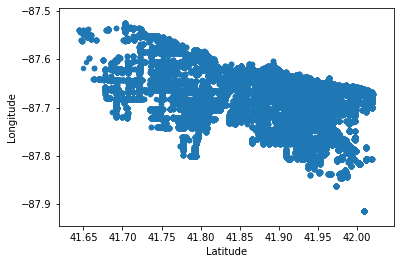

In [78]:
# Drop location with missing latitude or longitude
no_location = cfi[cfi['Latitude'].isnull() | cfi['Longitude'].isnull()].index
cfi.drop(no_location, inplace = True)

# Plot the locations
cfi.plot.scatter(x = 'Latitude', y ='Longitude')
plt.show()

This scatter plot shows that all of the data does seem to really be in Chicago or in the surrounding area.

### 4. Adjusting columns

#### a) The Risk column
Simplify the risk column to a risk with an integer value from 1-3.

In [79]:
# Converting the Risk column to int values varying from 1-3 (Risk 1 = 1 etc.)
def risk_to_int(string):
    if string == 'Risk 1 (High)':
        return 1
    if string == 'Risk 2 (Medium)':
        return 2
    if string == 'Risk 3 (Low)':
        return 3

In [80]:
# Converting the risk columns to int values
cfi['Risk']=cfi['Risk'].apply(risk_to_int)

#### b) The Inspection Date column
Use the date formate in the Inspection Date column for future use.

In [81]:
# Convert Inspection date in date format
cfi['Inspection Date'] = cfi['Inspection Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

#### c) The unused columns: AKA Name and Location
Drop the columns that are of no use in our analyses.

In [82]:
# Drop unused columns
cfi.drop(columns = ['AKA Name', 'Location'], inplace = True)

#### d) Add a column: Community Area Code

This will be useful when working with together with the crimes dataset to match the information into geographical groups.

In [83]:
# create a new column storing the Point necessary for polygon testing later on
cfi['Location Point'] = cfi.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)

In [84]:
# get the data of the boundaries from the geojson file
area_geo_path = r'data/boundaries.geojson'
geo_json_data = json.load(open(area_geo_path))

# define the polygons and corresponding area codes for all areas 
polygons_list = []
areacode_list = []
for feature in geo_json_data['features']:
    polygons_list.append(shape(feature['geometry']))
    areacode_list.append(int(feature['properties']['area_num_1']))

In [85]:
def find_area(point):
    for idx, polygon in enumerate(polygons_list):
        if polygon.contains(point):
            return areacode_list[idx]
    return np.nan

In [86]:
cfi['Community Area'] = cfi['Location Point'].apply(lambda x: find_area(x))

In [87]:
cfi['Community Area'].isnull().sum()

2398

In [90]:
cfi.drop(columns=['Location Point'], inplace = True)

Should inquire more where the Nan's come from: due to nans in longitude/latitude or function not working perfectly?

# ALSO: move food chain column up here!

### 5. Group establishments for an establishment-centric dataframe

In [91]:
# Generate groups according to license number
groups = cfi.groupby(['License #'])

# Aggregates other columns either in a list format or by taking the mode
columns = (list(cfi.columns))
columns.remove('License #')
columns_to_list = ['Inspection ID', 'Inspection Date', 'Inspection Type', 'Results', 'Violations']

for i, col in enumerate(columns):
    if(col not in columns_to_list): # Take the mode value
        df = groups[col].agg(pd.Series.mode).reset_index(name=col)
    else: # Aggregate the resluts in a list
        df = groups[col].apply(list).reset_index(name=col)
        
    if(i==0):
        cfi_groups = df
    else:
        cfi_groups = cfi_groups.merge(df, on = ['License #'])

# The results of the transformations
cfi_groups.head(3)

License #                                      Inspection ID  \
0        2.0  [2144871, 2050308, 1977093, 1970902, 1970312, ...   
1        9.0  [2304407, 2181605, 2181227, 2050713, 1975322, ...   
2       40.0  [2222357, 2151032, 2079140, 2078535, 2072109, ...   

                                 DBA Name Facility Type Risk  \
0                                    COSI    Restaurant    1   
1  XANDO COFFEE & BAR / COSI SANDWICH BAR    Restaurant    1   
2                                    COSI    Restaurant    1   

               Address     City State    Zip  \
0     230 W MONROE ST   CHICAGO    IL  60606   
1  116 S MICHIGAN AVE   CHICAGO    IL  60603   
2  233 N MICHIGAN AVE   CHICAGO    IL  60601   

                                     Inspection Date  \
0  [2018-02-13 00:00:00, 2017-05-12 00:00:00, 201...   
1  [2019-08-09 00:00:00, 2018-06-19 00:00:00, 201...   
2  [2018-09-14 00:00:00, 2018-03-27 00:00:00, 201...   

                                     Inspection Type  \
0  [Canvass, Canvass, Short Form Complaint, Canva...   
1  [Canvass, Canvass Re-Inspection, Canvass, Canv...   
2  [Complaint, Canvass, Complaint Re-Inspection, ...   

                                             Results  \
0  [Pass w/ Conditions, Pass, Pass w/ Conditions,...   
1  [Pass w/ Conditions, Pass, Fail, Pass, Pass, P...   
2  [Pass w/ Conditions, Pass, Pass, Fail, Fail, P...   

                                          Violations Latitude Longitude  \
0  [3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATU...  41.8808  -87.6347   
1  [1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNO...  41.8804  -87.6245   
2  [2. CITY OF CHICAGO FOOD SERVICE SANITATION CE...  41.8866  -87.6244   

  Community Area  
0             32  
1             32  
2             32

### 6. Final data sets

#### The establishments need to still be open today

Establishments must be visited at least every three years (for the lowest risk establishments, more for the higher risks). Thus, since we will be comparing our data with the Yelp dataset, we will remove the establishments that have not been inspected in the last three years. We assume that this means the has shut down and thus a comparison with the current data in Yelp would be nonsensical. 

First we will apply these transformations to the <b>establishment-centric</b> dataframe: 

In [92]:
# Generate the new dataset with places that have been inspected at least once in the last three years 
print('Size CFI establishment-centric dataframe:', cfi_groups.shape[0])

# For the dataset with each row containing one establishment
cfi_groups['DBA Name'] = cfi_groups['DBA Name'].apply(lambda x: str(x).lower())
cfi_groups.loc[:, 'Last Inspection Year'] = cfi_groups['Inspection Date'].map(lambda x: x[0].year)
cfi_recent = cfi_groups[cfi_groups['Last Inspection Year'] > 2015].reset_index()
print('Size of CFI establishment-centric dataframe after dropping non-inspected places:', cfi_recent.shape[0])

Size CFI establishment-centric dataframe: 20323
Size of CFI establishment-centric dataframe after dropping non-inspected places: 12869


Doing the same for the <b>inspection-centric</b> dataframe:

In [93]:
# For the dataset with each row containing one inspection

cfi['DBA Name'] = cfi['DBA Name'].apply(lambda x: str(x).lower())

# Get the inspection year
cfi.loc[:, 'Inspection Year'] = cfi['Inspection Date'].map(lambda x: x.year)

# Get the last year of inspection
cfi_max_year = cfi.loc[cfi.groupby('License #')['Inspection Year'].idxmax()]
cfi_max_year.rename(columns = {'Inspection Year': 'Last Inspection Year'}, inplace = True)

# Merge this dataframe with the original CFI inspections
cfi = cfi.merge(cfi_max_year, on = 'License #')
to_drop = [x for x in cfi if x.endswith('_y')]
cfi.drop(to_drop, axis=1, inplace=True)
cfi.rename(columns = {'Inspection ID_x': 'Inspection ID', 'DBA Name_x': 'DBA Name', \
                      'Facility Type_x': 'Facility Type', 'Risk_x': 'Risk', 'City_x': 'City', \
                      'State_x': 'State', 'Zip_x': 'Zip', 'Inspection Date_x': 'Inspection Date',\
                      'Inspection Type_x': 'Inspection Type', 'Latitude_x': 'Latitude', \
                      'Longitude_x':'Longitude', 'Violations_x': 'Violations', 'Results_x': 'Results',\
                      'Address_x': 'Address'}, inplace = True)
print('Size CFI inspection-centric dataframe:', cfi.shape[0])

# Drop all the rows where the Last Inspection Year is less than or equal to 2016. 
cfi_insp = cfi[cfi['Last Inspection Year'] > 2015].reset_index()
print('Size of CFI inspection-centric dataframe after dropping non-inspected places:', cfi_insp.shape[0])

Size CFI inspection-centric dataframe: 125600
Size of CFI inspection-centric dataframe after dropping non-inspected places: 100693


#### Adding a column to indicate food chains

Now let's make a dataset grouping the food chains. According to Wikipedia, the top 15 biggest food chains of the US are: Subway, McDonald's, Starbucks, KFC, Burger King, Pizza Hut, Domino's, Dunkin', Baskin-Robbins, Hunt Brothers Pizza, Taco Bell, Wendy's, Hardee's, Orange Julius and Papa John's Pizza.

In [94]:
def get_chain_column(df,cutoff):
    names = df['DBA Name']
    df['Chain'] = np.nan
    for i, name in enumerate(names):
        match = get_close_matches(name,top_15_chains,n=1,cutoff=cutoff)
        if(match):
            df.loc[i,'Chain'] = match
    return df

In [95]:
top_15_chains = ['subway', 'mcDonald\'s', 'starbucks', 'kfc', 'burger king', 'pizza hut', 'domino\'s',\
                 'dunkin\'', 'baskin-robbins', 'hunt brothers pizza', 'taco bell', 'wendy\'s',\
                 'hardee\'s', 'orange julius', 'papa john\'s pizza']

cutoff = 0.9

# For the establishment-centric dataframe
cfi_recent = get_chain_column(cfi_recent,cutoff)
        
# For the inspection-centric dataframe
cfi_insp = get_chain_column(cfi_insp,cutoff)

#### Saving the cleaned datasets

In [96]:
# Save the cleaned dataset: one row is one establishment
cfi_recent.to_csv('data/cfi_recent.csv')

# Save the cleaned dataset: each row if one inspection
cfi_insp.to_csv('data/cfi_insp.csv')

## Crimes dataset

### 1. Exploring columns

In [25]:
print(crimes.dtypes)

ID                              int64
Case Number                    object
Date                           object
Block                          object
IUCR                           object
Primary Type                   object
Description                    object
Location Description           object
Arrest                           bool
Domestic                         bool
Beat                            int64
District                      float64
Ward                          float64
Community Area                float64
FBI Code                       object
X Coordinate                  float64
Y Coordinate                  float64
Year                            int64
Updated On                     object
Latitude                      float64
Longitude                     float64
Location                       object
Historical Wards 2003-2015    float64
Zip Codes                     float64
Community Areas               float64
Census Tracts                 float64
Wards       

The dataset is also available directly on [Chicago's data portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), where it comes with a nice explanation of the columns that helps understand the meaning of all 30 features.

> **ID** - Unique identifier for the record. <br>
**Case Number** - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.<br>
**Date** - Date when the incident occurred. this is sometimes a best estimate.<br>
**Block** - The partially redacted address where the incident occurred, placing it on the same block as the actual address.<br>
**IUCR** - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.<br>
**Primary Type** - The primary description of the IUCR code.<br>
**Description** - The secondary description of the IUCR code, a subcategory of the primary description.<br>
**Location Description** - Description of the location where the incident occurred.<br>
**Arrest** - Indicates whether an arrest was made.<br>
**Domestic** - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.<br>
**Beat** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.<br>
**District** - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.<br>
**Ward** - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.<br>
**Community Area** - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.<br>
**FBI Code** - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.<br>
**X Coordinate** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Y Coordinate** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Year** - Year the incident occurred.<br>
**Updated On** - Date and time the record was last updated.<br>
**Latitude** - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Longitude** - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Location** - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.<br>

In addition, we can see based on their website's information that in fact only 22 columns instead of 30 contain valuable information. The remaining 8 columns in fact pertain to an older classification system that we don't need to take into account. Therefore, we drop these columns for our analysis.

In [26]:
# drop old columns
cols = ['Historical Wards 2003-2015','Zip Codes', 'Community Areas', 'Census Tracts', 
        'Wards', 'Boundaries - ZIP Codes','Police Districts', 'Police Beats']
crimes.drop(cols, axis=1, inplace=True)

In [27]:
with pd.option_context('display.max_columns', None): display(crimes.head())

ID Case Number                    Date                 Block  IUCR  \
0  11034701    JA366925  01/01/2001 11:00:00 AM       016XX E 86TH PL  1153   
1  11227287    JB147188  10/08/2017 03:00:00 AM    092XX S RACINE AVE  0281   
2  11227583    JB147595  03/28/2017 02:00:00 PM       026XX W 79TH ST  0620   
3  11227293    JB147230  09/09/2017 08:17:00 PM  060XX S EBERHART AVE  0810   
4  11227634    JB147599  08/26/2017 10:00:00 AM   001XX W RANDOLPH ST  0281   

          Primary Type                          Description  \
0   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
1  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   
2             BURGLARY                       UNLAWFUL ENTRY   
3                THEFT                            OVER $500   
4  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   

  Location Description  Arrest  Domestic  Beat  District  Ward  \
0            RESIDENCE   False     False   412       4.0   8.0   
1            RESIDENCE   False     False  2222      22.0  21.0   
2                OTHER   False     False   835       8.0  18.0   
3            RESIDENCE   False     False   313       3.0  20.0   
4          HOTEL/MOTEL   False     False   122       1.0  42.0   

   Community Area FBI Code  X Coordinate  Y Coordinate  Year  \
0            45.0       11           NaN           NaN  2001   
1            73.0       02           NaN           NaN  2017   
2            70.0       05           NaN           NaN  2017   
3            42.0       06           NaN           NaN  2017   
4            32.0       02           NaN           NaN  2017   

               Updated On  Latitude  Longitude Location  
0  08/05/2017 03:50:08 PM       NaN        NaN      NaN  
1  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
2  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
3  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
4  02/11/2018 03:57:41 PM       NaN        NaN      NaN

### 2. Cleaning entries

As we have seen in the data collection part, the whole dataset includes almost 7M entries and 30 columns. However, only roughly 3M entries pertain to our study period (2010 until present) to match with the CFI dataset.

In [28]:
# Only use data from January 1st, 2010 onwards
crimes = crimes[crimes['Year'] > 2009]

Let's also have a look at any missing values for each feature:

In [29]:
crimes.isnull().sum()

ID                          0
Case Number                 2
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     5595
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       59
Community Area            401
FBI Code                    0
X Coordinate            21028
Y Coordinate            21028
Year                        0
Updated On                  0
Latitude                21028
Longitude               21028
Location                21028
dtype: int64

Based on these results, we decide to drop all entries with a nan value in any feature except location description, as this will anyways not be part of our analysis.

In [30]:
nan_entries = crimes[['Case Number', 'District', 'Ward', 'Community Area', 'Latitude', 'Longitude']]\
                    .isnull().sum(axis=1)
print('There are {0} entries with at least one missing value in our targeted features'.format((nan_entries>0).sum()))
crimes = crimes[nan_entries<1]
print('After cleaning, there are {0} remaining samples'.format(crimes.shape[0]))

There are 21473 entries with at least one missing value in our targeted features
After cleaning, there are 2894407 remaining samples


### 3. Cleaning columns

Let's now turn our attention to the features in our dataset. 

In [31]:
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

Some columns will not be relevant for our analysis and we hence drop them. The X and Y coordinate are not necessary given that we work with the longitude/latitude data and location is simply an aggregate of the longitude and latitude. Also, we are not really interested in the location description and the update dates of the log entries for the purposes of our analysis.

In [32]:
# drop unnecessary columns
cols = ['Location Description', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Location']
crimes.drop(cols, axis=1, inplace=True)

Also, we make sure that the data type of our features matches with its meaning and that it allows easy usage.

In [33]:
# convert floats to integers
crimes[['District', 'Ward', 'Community Area']] = crimes[['District', 'Ward', 'Community Area']].astype(int)

# convert booleans to integers (in python, True = 1 and False = 0)
crimes[['Arrest', 'Domestic']] = crimes[['Arrest', 'Domestic']].astype(int)

# structure the date and time for better usability
crimes['Date'] = crimes['Date'].apply(lambda d: datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p'))

### 4. Detecting outliers

#### 4.1 Geographical data

Let's check the crimes distribution by location:

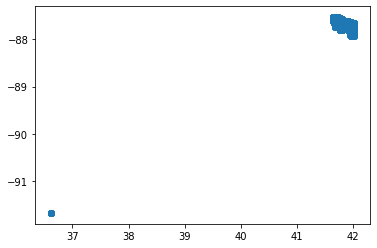

In [34]:
plt.scatter(crimes['Latitude'], crimes['Longitude'])

We realize that there must be some entries that do not correspond to the city of Chicago, whose latitude/longitude is 41.8781° N, 87.6298° W. Therefore, we are going to exclude datapoints below 40° latitude and -90° longitude:

In [35]:
in_chigaco = (crimes['Longitude'] > -90) & (crimes['Latitude'] > 40)
print('There are {0} entries with a location outside of Chicago'.format(crimes.shape[0]-in_chigaco.sum()))
crimes = crimes[in_chigaco]

There are 76 entries with a location outside of Chicago


Let's recheck whether the geographical distribution now makes sense:

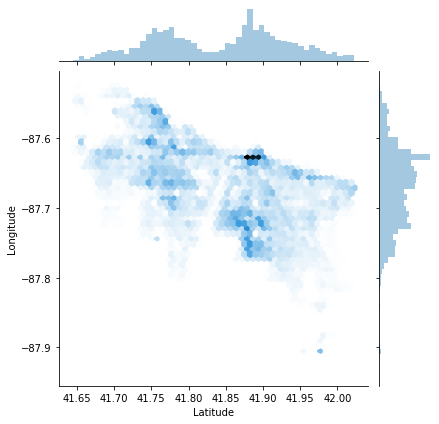

In [36]:
sns.jointplot(x=crimes['Latitude'], y=crimes['Longitude'], kind='hex')

#### 4.2 Community area data

It is known that Chicago has 77 community areas, numbered from 1 to 77. Let's therefore discard any values different from this range.

In [37]:
areas = np.arange(1,78)
in_areas = crimes['Community Area'].isin(areas)
print('There are {0} entries with a wrong area code'.format(crimes.shape[0]-in_areas.sum()))
crimes = crimes[in_areas]

There are 9 entries with a wrong area code


Also, Chicago has 25 police districts, numbered 1 to 25. 

In [38]:
districts = np.arange(1,26)
in_districts = crimes['District'].isin(districts)
print('There are {0} entries with a wrong district code'.format(crimes.shape[0]-in_districts.sum()))
crimes = crimes[in_districts]

There are 57 entries with a wrong district code


## Yelp Reviews (YR) dataset

The data scraped from Yelp has been directly added on the clean version of our primary CFI dataset by just adding 3 columns: the Yelp name of the business, the number of reviews and the rating. We added the Yelp name just to see if the business obtained was the one that we were looking for. Thus, we will have for every restaurants, the rating of the business (which is computed as the mean of all the reviews) and the total number of reviews. For the format of these columns, the rating is a float, and the number of reviews is an int. Note that the rating only take some finite values (from 0 to 5, with increments of 0.5).

Of course, we weren't able to obtain information on every restaurant (for instance, some of them might not have a Yelp page, other restaurants might have shutdown in the meantime and thus they don't have a Yelp page anymore, and finally in some cases, we might just have issues with the querying). On average, we were able to obtain information on 75% of our dataset, which is a nice proportion taking into account all of the issues mentionned above. Note that by default the business for which we didn't have any Yelp information have the Yelp columns filled with NaN values.

Note, to be able to do the scraping, we used the clean dataset called "cfi_recent". Indeed, in this dataset, each rows represents one restaurant, and thus, we don't query twice for the same restaurant (if we would have used the inspection-centric dataset). Moreover, we won't have to do any cleaning on this dataset, as it is simply added on this previously cleaned dataset. The information obtained from Yelp is already in the right format. We might just, as stated above, have some lines with NaN values in our merged dataset (CFI + Yelp).

In [34]:
#Load the data scraped
data_scrapped = pd.read_csv('data/food-inspections_scrapped.csv',usecols = ['License #','Yelp name','Yelp review count','Yelp rating'])

In [35]:
#Add the three Yelp columns on the cfi_recent dataframe
cfi_recent = cfi_recent.merge(data_scrapped, on='License #')

In [36]:
cfi_recent.head(3)

index  License #                                      Inspection ID  \
0      0        2.0  [2144871, 2050308, 1977093, 1970902, 1970312, ...   
1      1        9.0  [2304407, 2181605, 2181227, 2050713, 1975322, ...   
2      2       40.0  [2222357, 2151032, 2079140, 2078535, 2072109, ...   

                                 DBA Name Facility Type Risk  \
0                                    cosi    Restaurant    1   
1  xando coffee & bar / cosi sandwich bar    Restaurant    1   
2                                    cosi    Restaurant    1   

               Address     City State    Zip  ...  \
0     230 W MONROE ST   CHICAGO    IL  60606  ...   
1  116 S MICHIGAN AVE   CHICAGO    IL  60603  ...   
2  233 N MICHIGAN AVE   CHICAGO    IL  60601  ...   

                                     Inspection Type  \
0  [Canvass, Canvass, Short Form Complaint, Canva...   
1  [Canvass, Canvass Re-Inspection, Canvass, Canv...   
2  [Complaint, Canvass, Complaint Re-Inspection, ...   

                                             Results  \
0  [Pass w/ Conditions, Pass, Pass w/ Conditions,...   
1  [Pass w/ Conditions, Pass, Fail, Pass, Pass, P...   
2  [Pass w/ Conditions, Pass, Pass, Fail, Fail, P...   

                                          Violations Latitude Longitude  \
0  [3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATU...  41.8808  -87.6347   
1  [1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNO...  41.8804  -87.6245   
2  [2. CITY OF CHICAGO FOOD SERVICE SANITATION CE...  41.8866  -87.6244   

  Last Inspection Year  Chain Yelp name Yelp review count  Yelp rating  
0                 2018    NaN      Cosi              70.0          3.0  
1                 2019    NaN       NaN               NaN          NaN  
2                 2018    NaN      Cosi              51.0          3.0  

[3 rows x 21 columns]

---

# <p style="color:#2e86c1">Descriptive analysis 

>Our research questions defined in the README give us a good framework for our descriptive analysis. Up to the second milestone, we aimed to:
>- evolution of the food inspection results
>- food chains / food categories (type of cuisine, facility type etc.)
>- a possible correlation of hygienic standards of the food places and their respective customer reviews
>- patterns of neighborhood crime rates

## Evolution of food inspection results

* How did the food safety in Chicago evolve since the year 2010? (Overall & geographically)
* Does the same area/restaurants remain safe over time?

#### 1. Ratio of pass/fail over time

In [39]:
print('The distinct different results of inspection:', cfi['Results'].unique())

# Convert the 'No Entry' and the 'Not Ready' into NaN values in the dataframe
cfi_insp[(cfi_insp['Results'] == 'No Entry') | (cfi_insp['Results'] == 'Not Ready')] = np.nan
print('After removing:', cfi_insp['Results'].unique())

# For each year, compute the pass/fail ratio
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

ratio_passw = [] # will contain ratio of (pass + pass w/ cond)/fail
ratio_pass = [] # will contain ratio of pass/fail

for year in years:
    pass_condi = cfi_insp[(cfi_insp['Inspection Year'] == year) & (cfi_insp['Results'] == 'Pass w/ Conditions')].shape[0]
    pass_ = cfi_insp[(cfi_insp['Inspection Year'] == year) & (cfi_insp['Results'] == 'Pass')].shape[0]
    fail_ = cfi_insp[(cfi_insp['Inspection Year'] == year) & (cfi_insp['Results'] == 'Fail')].shape[0]
    ratio_passw.append((pass_+pass_condi)/fail_)
    ratio_pass.append(pass_/fail_)
ratio_years = pd.DataFrame(list(zip(ratio_pass, ratio_passw)), index = years, columns = ['Pass/Fail', '(Pass + Pass w conditions)/Fail'])

The distinct different results of inspection: ['Pass w/ Conditions' 'No Entry' 'Pass' 'Fail' 'Not Ready']
After removing: ['Pass w/ Conditions' nan 'Pass' 'Fail']


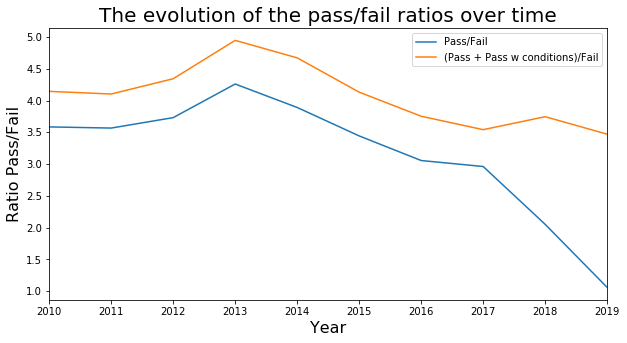

In [40]:
ratio_years.plot(figsize=(10, 5))
plt.title('The evolution of the pass/fail ratios over time', Fontsize = 20)
plt.ylabel('Ratio Pass/Fail', Fontsize = 16)
plt.xlabel('Year', Fontsize = 16)
plt.show()

Analysis of the results:
* Firstly, one can notice that the both ratios remain over a value of 1, thus the number of Pass results is always higher than the number of Fail results. 
* The results above show a seemingly significant decrease in the pass/fail ratio starting in 2018. This can be explained by the recent change in the definition of violations by the Chicago Department of Public Health’s Food Protection on the 1st of July 2018. The original description of the dataset mentionned that these changes in the violations could lead to a change in the distribution of the Results (Pass, Pass w/ Conditions or Fail). It seems that there has been an increase in the results with "Pass w/ Conditions" rather than simply "Pass" due to the changes that occurred in 2018.
* Other than this significant decrease in the pass/fail ratio starting in 2018, the two curves follow the same trend, with 2013 being the most successful year. 

#### 2. The Inspection Type over time
The inspection type can give valuable information as to whether the inspection was standard procedure, or due to a complaint. Thus, we will analyse the evolution of the inspection types over time.

In [41]:
cfi_insp['Inspection Type'].unique()

# Making a list og the Inspection Types showing some sort of complaint
complaint_insp = ['Complaint Re-Inspection', 'Short Form Complaint', \
        'Suspected Food Poisoning Re-inspection', 'Suspected Food Poisoning', \
        'Complaint-Fire Re-inspection', 'Complaint-Fire', 'Short Form Fire-Complaint']

ratio_complaint = []

for year in years:
    complaint = cfi_insp[(cfi_insp['Inspection Year'] == year) & (cfi_insp['Inspection Type'].isin(complaint_insp))].shape[0]
    other = cfi[(cfi['Inspection Year'] == year) & ~(cfi_insp['Inspection Type'].isin(complaint_insp))].shape[0]
    ratio_complaint.append(other/complaint)
ratio_years_complaint = pd.DataFrame(ratio_complaint, index = years, columns = ['Complaint Inspection/Other'])

In [42]:
# Append this ratio to the ratio_years DataFrame
ratio_years = ratio_years.join(ratio_years_complaint)

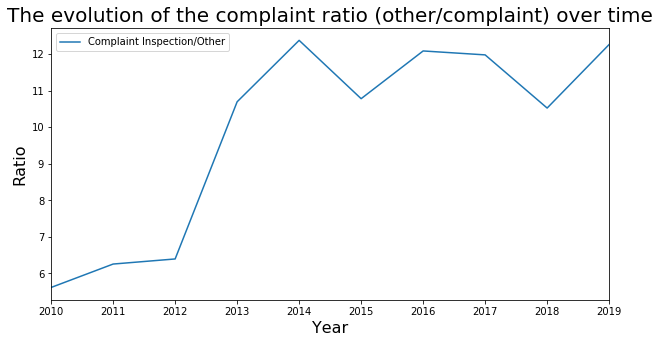

In [43]:
ratio_years_complaint.plot(figsize=(10, 5))
plt.title('The evolution of the complaint ratio (other/complaint) over time', Fontsize = 20)
plt.ylabel('Ratio', Fontsize = 16)
plt.xlabel('Year', Fontsize = 16)
plt.show()

Analysis:
* The ratio of other/complaints seems to have drastically increased in 2013 compared to 2012 and then remaining stable around 11-12. Perhaps this shows that the hygiene increased significantly in this period of time, and stabilized later on.

To get better insight, we will compare the number of each type of complaint between 2010, 2013 and 2019.

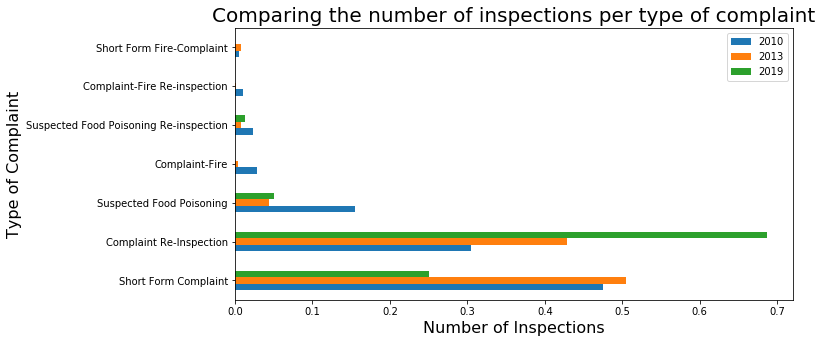

In [44]:
# Creating series with the number of inspection types for 2010, 2013, and 2019
complaint_2010 = cfi_insp[cfi_insp['Inspection Year'] == 2010]['Inspection Type'].value_counts().to_frame()
complaint_2013 = cfi_insp[cfi_insp['Inspection Year'] == 2013]['Inspection Type'].value_counts().to_frame()
complaint_2019 = cfi_insp[cfi_insp['Inspection Year'] == 2019]['Inspection Type'].value_counts().to_frame()

# Only choose the Inspection Types that are 'complaints'
complaint_2010 = complaint_2010[complaint_2010.index.isin(complaint_insp)]
complaint_2013 = complaint_2013[complaint_2013.index.isin(complaint_insp)]
complaint_2019 = complaint_2019[complaint_2019.index.isin(complaint_insp)]

# Normalize each year by the total number of complaint Inspection Types
complaint_2010['Inspection Type'] = complaint_2010['Inspection Type']/(complaint_2010['Inspection Type'].sum())
complaint_2013['Inspection Type'] = complaint_2013['Inspection Type']/(complaint_2013['Inspection Type'].sum())
complaint_2019['Inspection Type'] = complaint_2019['Inspection Type']/(complaint_2019['Inspection Type'].sum())

# Concatenate the results into a Dataframe 
compare_year_complaint = pd.concat([complaint_2010, complaint_2013, complaint_2019], axis = 1, sort = True)
compare_year_complaint.columns = ['2010', '2013', '2019']
compare_year_complaint.sort_values('2010', ascending = False, inplace = True)

# Plot
ax = compare_year_complaint.plot(kind='barh', figsize= (10,5))
ax.set_xlabel('Number of Inspections', Fontsize = 16)
ax.set_ylabel('Type of Complaint', Fontsize = 16)
plt.title('Comparing the number of inspections per type of complaint', Fontsize = 20)
plt.show()

Analysis of the evolution of the complaint inspection types:
* We can see that in 2019, the largest proportion of complaint inspection are Complaint Re-Inspections (approximately 70%), thus they are more follow-up inspections rather than new complaints. This is less the case for 2013, and even less for 2010. 
* Short Form Complaints are the more prominent in 2010, and 2013. 
* Suspected Food Poisoning is quite dramatically higher in 2010 (approximately 17%), compared to 2013 or 2019 (5%).
* It also seems that the Fire Complaints are more common in 2010 and 2013 than in 2019 (where they are not even visible).

Thus the conclusions that the number of complaints were higher in the first years between 2010-2013, seems to be grounded. Food poisoning complaints, and general complaints are higher and complaint re-inspections are lower. As mentioned before, this could be due to an increase in hygiene over time, and possibly also the effect of having more and more food chains in time, since the working conditions are likely to be more strictly controlled in these types of establishments. 

#### 3. Dynamic map of the evolution of food inspection results over time

To have a nice visualization of the evolution of food safety in Chicago, we created a dynamic maps using Folium. 
Note: for this task, it is better to use the inspection centric dataset ("cfi_insp").

In [97]:
with pd.option_context('display.max_columns', None): display(cfi_insp.head())

index  Inspection ID                  DBA Name  License # Facility Type  \
0      0        2320248     the redhead piano bar  2313942.0    Restaurant   
1      1        2320245     the redhead piano bar  2313945.0    Restaurant   
2      2        2320229  himalayan sherpa kitchen  2670751.0    Restaurant   
3      3        2293894  himalayan sherpa kitchen  2670751.0    Restaurant   
4      4        2316202             apollo's 2000    12125.0    Restaurant   

   Risk               Address     City State      Zip Inspection Date  \
0   3.0   16-18 W ONTARIO ST   CHICAGO    IL  60654.0      2019-10-22   
1   3.0   16-18 W ONTARIO ST   CHICAGO    IL  60654.0      2019-10-22   
2   1.0  2701 W LAWRENCE AVE   CHICAGO    IL  60625.0      2019-10-22   
3   1.0  2701 W LAWRENCE AVE   CHICAGO    IL  60625.0      2019-06-20   
4   1.0     2875 W CERMAK RD   CHICAGO    IL  60623.0      2019-10-21   

  Inspection Type             Results  \
0         License  Pass w/ Conditions   
1         License  Pass w/ Conditions   
2         Canvass  Pass w/ Conditions   
3         License  Pass w/ Conditions   
4         Canvass  Pass w/ Conditions   

                                          Violations   Latitude  Longitude  \
0                                                NaN  41.893371 -87.628783   
1  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.893371 -87.628783   
2  5. PROCEDURES FOR RESPONDING TO VOMITING AND D...  41.968442 -87.696304   
3  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.968442 -87.696304   
4  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.851748 -87.698583   

   Community Area_x  Inspection Year  Last Inspection Year Chain  
0               8.0             2019                  2019   NaN  
1               8.0             2019                  2019   NaN  
2               4.0             2019                  2019   NaN  
3               4.0             2019                  2019   NaN  
4              30.0             2019                  2019   NaN

In [98]:
#Function used to had a column color in the dataset, each color corresponding to wether the restaurants pass/pass with condition or failed the inspection
def results_to_color(s):
    '''
    Function creating a column color for our cfi_insp dataset
    
    Imput: 
            s: string containing the results of the inspection
    Output:
            color corresponding to the inspection: red if failed, orange if pass with conditions, green if pass
    '''
    if s=='Fail':
        return 'red'
    if s=='Pass':
        return 'green'
    if s=='Pass w/ Conditions':
        return 'orange'

In [99]:
cfi_insp['color'] = cfi_insp['Results'].apply(results_to_color)

In [100]:
#Note: this code has been inspired by an article written on the website TowardDataScience.

def create_geojson_features(df):
    '''
    This function enables us to create a dict of features, which will be later on used to create the dynamic map
    
    Imput: 
            df: Data set as a Pandas DataFrame
    Output: 
            features: Dictionnary of features
    '''
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['Longitude'],row['Latitude']]
            },
            'properties': {
                'time': str(row['Inspection Date'])[0:4] + '/' + str(row['Inspection Date'])[5:7], 
                'popup':row['DBA Name'],
                'style': {'highlight': {},'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

In [101]:
def make_map(features, duration=None):
    '''
    This function enables us to create the map, using the features created before.
    
    Imput:
            features: Dictionnary of features
            duration: Time that the point will stay on the map, None by default, meaning that the point will stay 
            forever on the map after having been put (other argument could by 'P1M' for instance, meaning that the 
            point will only stay one period of time)
    Output:
            Folium map containing the restaurants
    '''
    coords_chicago = [41.8781, -87.6298]
    chicago_map = folium.Map(location=coords_chicago, control_scale=True, zoom_start=10)
    
    data = TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1M'
        , duration=duration
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM'
        , time_slider_drag_update=True
    ).add_to(chicago_map)
    
    #folium.GeoJson(data, name='Schools', tooltip=folium.features.GeoJsonTooltip(fields=['SCHOOL_NAME'], localize=True)).add_to(chicago_map)
    #folium.GeoJson(tooltip=folium.features.GeoJsonTooltip(fields=['SCHOOL_NAME', 'ADDRESS'], localize=True)).add_to(chicago_map)
    #tooltip=folium.features.GeoJsonTooltip(fields=['SCHOOL_NAME', 'ADDRESS'], localize=True)

    return chicago_map

In [102]:
def create_the_map(df, N, duration):
    '''
    This function used the previous function to created the features and the map associated with it. Note that, we have
    to take a subsample of our dataset if we used to put a None for the duration, otherwise, the maps becomes too crowded
    and is not readable anymore.
    
    Imput:
            df: Data set as a Pandas DataFrame
            N: Number of samples that we want to take from our dataset
            duration: Time that the point will stay on the map, None by default, meaning that the point will stay 
            forever on the map after having been put (other argument could by 'P1M' for instance, meaning that the 
            point will only stay one period of time)
    Output:
            Folium map containing the restaurants   
            
    '''
    data = df.sample(N) #Only take a subsample of our dataset to not obtain something too crowded
    features = create_geojson_features(data)
    return make_map(features, duration)

In [103]:
#First, we plotted a map on which the restaurants stayed forever (duration = None)
#For this task, we obviously can't take the full dataset, and need to take a subsample of it 
map_1 = create_the_map(cfi_insp, 2000, None)
map_1.save('map_evolution_inspection_sample.html')
map_1

The map can be seen [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/map_evolution_inspection_sample.html).

In [104]:
#Second, we plotted a map on which the restaurants stayed forever (duration = None)
#For this task, as the point disappear, we can take the full dataset
map_2 = create_the_map(cfi_insp, 90000, 'P1M')
map_2.save('map_evolution_inspection_full.html')

The map can be seen [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/map_evolution_inspection_full.html).

In [50]:
#Now, we can drop the color column
cfi_insp = cfi_insp.drop('color', axis=1)

## Analysis of food chains and categories

Are large food chains or specific cuisine types more prone to fail food inspections?

In [219]:
# We take only the data for wich the chain is known and remove the one having <10 restaurants
cfi_recent_chain = cfi_recent[~cfi_recent['Chain'].isin(['wendy\'s','baskin-robbins'])].dropna()
cfi_insp_chain = cfi_insp[~cfi_insp['Chain'].isin(['wendy\'s','baskin-robbins'])].dropna()

chain_list = list(cfi_recent_chain['Chain'].unique())

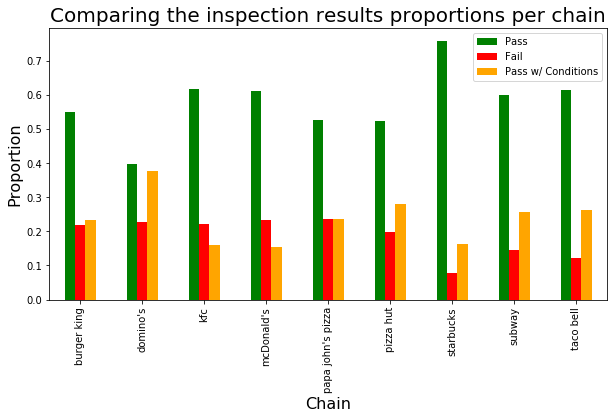

In [220]:
# Creating series with the inspection results for each chain
chain_pass = cfi_insp_chain[cfi_insp_chain['Results'] == 'Pass']['Chain'].value_counts().to_frame(name = 'Pass')
chain_fail = cfi_insp_chain[cfi_insp_chain['Results'] == 'Fail']['Chain'].value_counts().to_frame(name = 'Fail')
chain_passWC = cfi_insp_chain[cfi_insp_chain['Results'] == 'Pass w/ Conditions']['Chain'].value_counts().to_frame(name = 'Pass w/ Conditions')
chain = chain_pass.join(chain_fail,how='outer').join(chain_passWC,how='outer')
chain = chain.fillna(0)

# Normalize by total number of inspection results
chain['Sum'] = chain['Pass'] + chain['Fail'] + chain['Pass w/ Conditions']
chain['Pass'] = chain['Pass']/chain['Sum']
chain['Fail'] = chain['Fail']/chain['Sum']
chain['Pass w/ Conditions'] = chain['Pass w/ Conditions']/chain['Sum']
chain.drop(columns=['Sum'],inplace=True)

# Plot
ax = chain.plot(kind='bar', figsize= (10,5), color = ['green','red','orange'])
ax.set_xlabel('Chain', Fontsize = 16)
ax.set_ylabel('Proportion', Fontsize = 16)
plt.title('Comparing the inspection results proportions per chain', Fontsize = 20)
plt.show()

We can see that starbucks has the lowest fail rate and the highest pass rate. All chain are not exceeding 25% of failure. Domino's has the lowest pass rate but also the highest pass with condition rate.

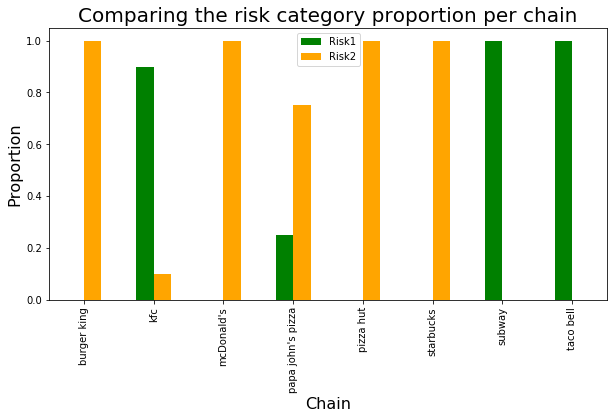

In [221]:
# Creating series with risk catergories for each chain
chain_R1 = cfi_recent_chain[cfi_recent_chain['Risk'] == 1]['Chain'].value_counts().to_frame(name = 'Risk1')
chain_R2 = cfi_recent_chain[cfi_recent_chain['Risk'] == 2]['Chain'].value_counts().to_frame(name = 'Risk2')
chain = chain_R1.join(chain_R2,how='outer')
chain = chain.fillna(0)

# Normalize by number of restaurant with a risk category
chain['Sum'] = chain['Risk1'] + chain['Risk2']
chain['Risk1'] = chain['Risk1']/chain['Sum']
chain['Risk2'] = chain['Risk2']/chain['Sum']
chain.drop(columns=['Sum'],inplace=True)

# Plot
ax = chain.plot(kind='bar', figsize= (10,5), color = ['green','orange'])
ax.set_xlabel('Chain', Fontsize = 16)
ax.set_ylabel('Proportion', Fontsize = 16)
plt.title('Comparing the risk category proportion per chain', Fontsize = 20)
plt.show()

Here one can observe that most chain have one risk category associated to most of its restaurants. Only subway, kfc and taco bell are classified as risk 1. There no obvious pattern considering this risk categorisation.

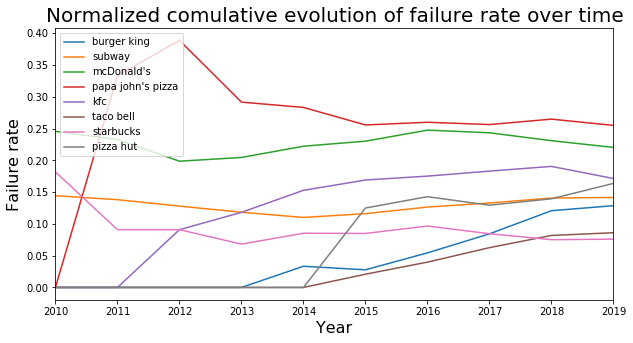

In [222]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# Initialize matrix to collect failure rates
ratio_fail = np.zeros([len(years),len(chain_list)])

for i, chain in enumerate(chain_list):
    activity_years = 0 # Counter of the number of years of activity (with at least one inspection)
    for j, year in enumerate(years):
        pass_condi = cfi_insp_chain[(cfi_insp_chain['Inspection Year'] == year)\
                                    & (cfi_insp_chain['Results'] == 'Pass w/ Conditions')\
                                    & (cfi_insp_chain['Chain'] == chain)].shape[0]
        pass_ = cfi_insp_chain[(cfi_insp_chain['Inspection Year'] == year)\
                                    & (cfi_insp_chain['Results'] == 'Pass')\
                                    & (cfi_insp_chain['Chain'] == chain)].shape[0]
        fail_ = cfi_insp_chain[(cfi_insp_chain['Inspection Year'] == year)\
                                    & (cfi_insp_chain['Results'] == 'Fail')\
                                    & (cfi_insp_chain['Chain'] == chain)].shape[0]
        
        # Number of inspections in this year
        sum_ = pass_+pass_condi+fail_
        
        if(j != 0): # If there was an inspection this year
            if(sum_ != 0):
                activity_years = activity_years + 1
                memory = memory + fail_/(sum_)
                ratio_fail[j,i] = memory/activity_years
            else: 
                memory = memory
                ratio_fail[j,i] = memory
        else: # If there wasn't any inspection this year
            if(sum_ != 0):
                activity_years = activity_years + 1
                memory = fail_/(sum_)
                ratio_fail[j,i] = memory/activity_years
            else: 
                memory = 0
                ratio_fail[j,i] = memory

ratio_years = pd.DataFrame(ratio_fail, index = years, columns = chain_list)

# Plot
ratio_years.plot(figsize=(10, 5))
plt.title('Normalized comulative evolution of failure rate over time', Fontsize = 20)
plt.ylabel('Failure rate', Fontsize = 16)
plt.xlabel('Year', Fontsize = 16)
plt.show()

As we can see on the graph above, the failure rate seems to have been quite stable in the last couple of years. Papa John's Pizza has the highest failure rate, and Starbucks the lowest. The establishments that had "zero" failure rate (Domino's and Papa John's Pizza) and all the sudden had a higher failure rate are likely establishments which were not existant before the year where the failure rate switched to being non-zero. 

## Correlation analysis  of hygienic standards of the food places and customer reviews

One of the questions that we wanted to address with the Yelp data was to see whether they were some correlation between the food inspection results and teh Yelp ratings. As stated before, we don't have the full set of ratings yet du to the Yelp API restriction. However, we still try to answer this question with the data that we presently have, knowing the fact that the conclusion that we draw now might change after with the full dataset.

#### Quick overview of the Yelp ratings and number of reviews

First, let's have a look at the distribution of the rating in our dataset.

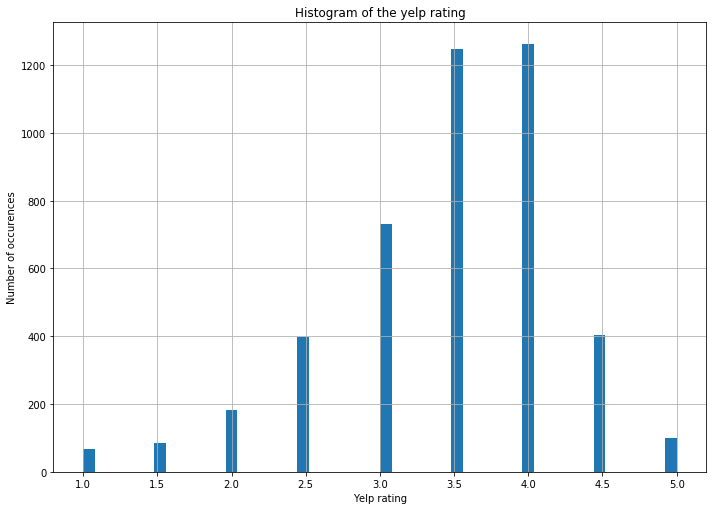

In [58]:
cfi_recent['Yelp rating'].hist(bins = 50)
plt.title('Histogram of the yelp rating')
plt.xlabel('Yelp rating')
plt.ylabel('Number of occurences')
plt.show()

As stated before, this distribution is a discrete one, as the Yelp rating only take values between 0 and 5, with 0.5 increments. Moreover, note that this distribution is bounded between 0 (minimum grade) and 5 (maximum grade).

Now, let's plot the distribution of the number of reviews per restaurants.

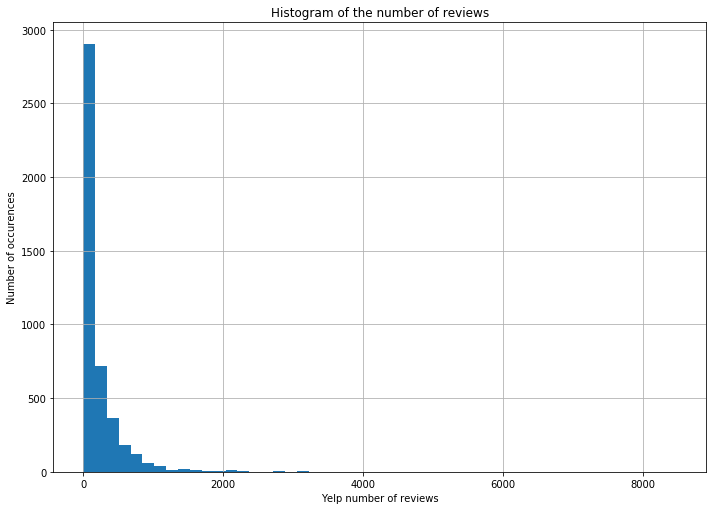

In [59]:
cfi_recent['Yelp review count'].hist(bins = 50)
plt.title('Histogram of the number of reviews')
plt.xlabel('Yelp number of reviews')
plt.ylabel('Number of occurences')
plt.show()

Note that once again, this distribution is discrete as the number of reviews can only be integer. However, from the previous plot, it seems that the distribution obtained follow a powerlaw, with most of the bussiness having only a small number of reviews, but still quite some outliers. This can be explained by the fact that some restaurants are very famous in Chicago, and thus obtained lot's of reviews on Yelp. One interesting thing to see is wheter the most famous places are also the "best" places. To do this, we can simply plot a scatter plot of the number vs the ratings.

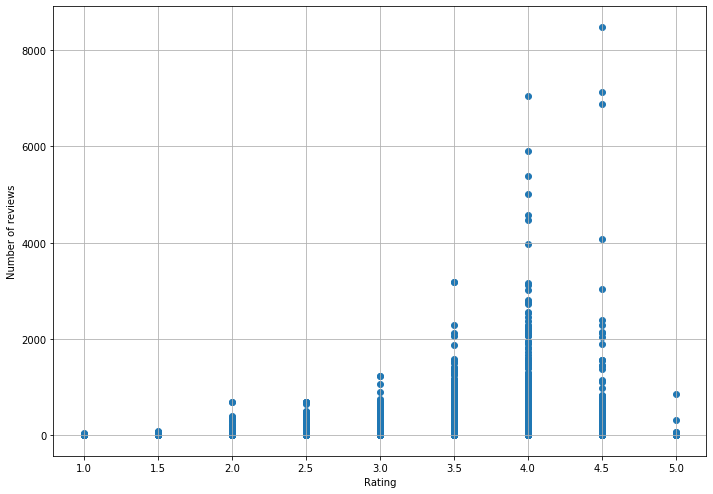

In [60]:
plt.scatter(cfi_recent['Yelp rating'], cfi_recent['Yelp review count'])
plt.grid()
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()

For now, and with the data that we have, there is no clear correlation between the number of reviews and the rating. Of course, the extremes ratings (0 and 5), always have very few number of reviews. It makes sense to assume the fact that after a certaing number of reviews, the restaurant cannot have a 5 star or a 1 star.

In [61]:
cfi_recent[['Yelp rating', 'Yelp review count']].corr()

Yelp rating  Yelp review count
Yelp rating           1.000000           0.200944
Yelp review count     0.200944           1.000000

The above correlation matrix confirms that there is a only a weak link between the rating and the number of reviews.

#### Correlates between the food inspection fail rate of areas and Yelp rating

Now, let's go back to our initial question and try to analyse whether we can find some correlation between the inspections and the Yelp rating.

*Important note: due to the fact that we haven't scraped the full dataset yet, all the results and interpretation bellow are subject to change and might not be true anymore with the full dataset.*

In [62]:
#Transform the results columns into a int number
def results_to_int(s):
    if s=='Pass':
        return 3
    if s=='Pass w/ Conditions':
        return 2
    if s=='Fail':
        return 1

In [63]:
cfi_insp['Results_int'] = cfi_insp['Results'].apply(results_to_int)

First, let's define as a proxy for assessing the goodness of the food inspection the following quantity S.
For each inspection that the restaurants had:
* S = S + 3 if the result is 'Pass'
* S = S + 2 if the result is 'Pass w/ Conditions'
* S = S + 1 if the result is 'Failed' 

And of course, we divide S by the number of inspection that the restaurants had.

In [64]:
temp = cfi_insp[['License #','Results_int']].groupby('License #').agg(['size','sum']) 
cfi_recent = cfi_recent.merge(pd.DataFrame(temp['Results_int']['sum']/temp['Results_int']['size']), on = 'License #')
cfi_recent.rename(columns={0:'Insp_results'},inplace = True)

First, let's have a look at the correlation between our proxy for the inspection results and the Yelp attributes.

In [65]:
cfi_recent[['Insp_results','Yelp rating','Yelp review count']].corr()

Insp_results  Yelp rating  Yelp review count
Insp_results           1.000000     0.001692          -0.080829
Yelp rating            0.001692     1.000000           0.201369
Yelp review count     -0.080829     0.201369           1.000000

As we can see on the cell above, quite astonishing, with the data that we have as of today, it seems that there is a negative correlation between the Yelp data and the inspection results! Now, let's try to fit some Machine Learning model to see whether or not we could relates the three quantities.

In [67]:
data = cfi_recent[['Insp_results','Yelp rating','Yelp review count']].dropna() #First we drop the NaN as we don't have scrap the full dataset yet
cut = int(data.shape[0]*0.8)

X_train = data[['Yelp rating', 'Yelp review count']].iloc[0:cut]
X_test = data[['Yelp rating', 'Yelp review count']].iloc[cut:data.shape[0]]
y_train = data['Insp_results'].iloc[0:cut]
y_test = data['Insp_results'].iloc[cut:data.shape[0]]

In [68]:
clf = LinearRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(r2_score(y_test, y_pred))

-0.024115418779884212


As we can see on the cell above, it seems that there is almost no linear relation between the inspection results and the Yelp attributes. For now this seem quite astonishing. Note however, and as stated before, this might change when we will have our full data from Yelp. 

Moreover, in the future, we will investigate maybe more complicate model than a simple linear regression. We first need to wait to have our all sample from Yelp before going any further for this part.

## Patterns of neighborhood crime rates

### Distribution of crimes among community areas

Chicago has 77 different community areas and our crimes dataset contains information about the community area where the incident occurred. Therefore, let's see whether there are some distinct patterns among these areas.

In [19]:
# get the total number of incidents per community area
cts = crimes['Community Area'].value_counts()
areas = pd.DataFrame(cts.values, cts.index, columns=["crimes"])
areas['code'] = areas.index
# convert the code into the string to allow for matching with geojson data later on
areas['code'] = areas['code'].apply(str)
areas.head()

crimes code
25  182705   25
8   107130    8
43   96816   43
23   91839   23
29   91613   29

We can now have a look at the data in a bar plot and see that there are huge differences among the different areas.

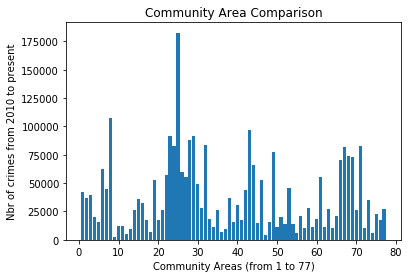

In [20]:
plt.bar(cts.index, cts.values)
plt.xlabel('Community Areas (from 1 to 77)')
plt.ylabel('Nbr of crimes from 2010 to present')
plt.title('Community Area Comparison')
plt.show()

The bar plot above shows that the community area 25 seems to have the highest number of crimes since 2010.

### Geographical distribution of crimes

Let's turn to folium and first just have a look at the different community area boundaries using [Chicago's Data Portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6) geojson data in the map visible [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/area_boundaries.html)

In [24]:
chicago_coord = [41.8781, -87.6298]
# define map
m = folium.Map(location=chicago_coord, tiles='cartodbpositron')
# get the data of the boundaries from the geojson file
area_geo_path = r'data/boundaries.geojson'
geo_json_data = json.load(open(area_geo_path))
# add the boundaries to the map
folium.GeoJson(geo_json_data).add_to(m)
# save the plot in html for rendering purposes
m.save(outfile= "data/area_boundaries.html")

#m

In [63]:
geo_json_data['features'][0]

{'type': 'Feature',
 'properties': {'community': 'DOUGLAS',
  'area': '0',
  'shape_area': '46004621.1581',
  'perimeter': '0',
  'area_num_1': '35',
  'area_numbe': '35',
  'comarea_id': '0',
  'comarea': '0',
  'shape_len': '31027.0545098'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-87.60914087617894, 41.84469250265398],
     [-87.60914874757808, 41.84466159842403],
     [-87.6091611204126, 41.84458961193954],
     [-87.60916766215838, 41.84451717732316],
     [-87.60916860600166, 41.844456260738305],
     [-87.60915012199398, 41.84423871659811],
     [-87.60907241249289, 41.844194738881015],
     [-87.60900627147821, 41.84410646928696],
     [-87.6089650217216, 41.84404345755115],
     [-87.60891566390615, 41.84395529375054],
     [-87.60889980118988, 41.84387361649532],
     [-87.60886701371862, 41.84380438280048],
     [-87.6088514342449, 41.843697606960866],
     [-87.60881089281094, 41.84357184776641],
     [-87.60877127222787, 41.84336451715353],
     [-87.608

As a next step, we want to add the information regarding the total number of crimes per community area since 2010 in the map:

In [25]:
# define the map
m = folium.Map(location=[41.8781, -87.6298], tiles='cartodbpositron')

# coloring is using data from a pandas dataframe bound to geojson data through the area code
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=areas,
    columns=['code', 'crimes'],
    key_on='feature.properties.area_num_1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total number of crimes from 2010 to present'
).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile= "data/area_counts.html")

#m

In the map visible [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/area_counts.html), we can now see that the different areas have a very different number of crimes as suggested by the barplot.

### Distribution of crime rate per population size

However, the incidence rate per population size would be even more informative to know which areas are problematic. To do so, we use the census data by community area from 2017 found [here](http://www.actforchildren.org/wp-content/uploads/2018/01/Census-Data-by-Chicago-Community-Area-2017.pdf) as a proxy for the population from 2010 to the present in each area.

In [21]:
census = pd.read_csv('data/census.csv', sep=';')
census.head()

code  count
0     1  53470
1     2  75185
2     3  54001
3     4  46881
4     5  35406

In [22]:
# convert the area code to int for the merge 
areas['code'] = areas['code'].astype(int)
areas = pd.merge(areas, census, how='inner', on='code')
# calculate the proportional incidence rate 
areas['prop'] = areas['crimes']/areas['count']
# reconvert the area code to string for binding with geojson data
areas['code'] = areas['code'].apply(str)
areas.head()

crimes code  count      prop
0  182705   25  97604  1.871901
1  107130    8  96466  1.110547
2   96816   43  42198  2.294327
3   91839   23  44841  2.048103
4   91613   29  36529  2.507953

In [26]:
# define the map
m = folium.Map(location=[41.8781, -87.6298], tiles='cartodbpositron')

# coloring is using data from a pandas dataframe bound to geojson data through the area code
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=areas,
    columns=['code', 'prop'],
    key_on='feature.properties.area_num_1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of crimes from 2010 to present per inhabitant'
).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile= "data/area_crimerate.html")

#m

In the map visible [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/area_crimerate.html), we can observe that the results have actually changed quite drastically compared to the absolute number of crimes. There are now more areas with a relatively elevated incidence score.

### Crime density per surface area

As it is difficult to get census data on all years we consider, we believe that it is more informative in the end to look at the crime density per surface area of each community area to understand the likelihood of a crime happening at a certain location. This also has the convenience that the surface area remains constant over the considered time period.

In [27]:
# add a column on surface area of the each community area
areas['surface'] = np.nan
for feature in geo_json_data['features']:
    idx = int(feature['properties']['area_num_1'])-1
    areas.loc[idx,'surface'] = area(feature['geometry'])

# calculate the number of crimes per surface area
areas['crimes density'] = areas['crimes']/areas['surface']    

In [28]:
# define the map
m = folium.Map(location=[41.8781, -87.6298], tiles='cartodbpositron')

# coloring is using data from a pandas dataframe bound to geojson data through the area code
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=areas,
    columns=['code', 'crimes density'],
    key_on='feature.properties.area_num_1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Density of crimes from 2010 to present per surface area'
).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile= "data/area_crimedensity.html")

m

In the map visible [here](https://huguesvinzant.github.io/ada-2019-project-jech/data/area_crimedensity.html), we can now see that the crime density based on the community area's surface is quite similar to the initial plot of absolute number of crimes independent of the other area's attributes.

### Evolution of crimes over the years

In [229]:
# get the number of crimes per community area and year
crimes_grouped = crimes.groupby(['Community Area', 'Year']).ID.count()
crimes_grouped = pd.DataFrame(crimes_grouped.values, crimes_grouped.index, columns=["Crimes"])
# create a column for each community area
crimes_grouped = crimes_grouped.unstack(level=0)
crimes_grouped.head()

Crimes                                                        \
Community Area     1     2     3     4     5     6     7      8    9     10   
Year                                                                          
2010             5570  4877  5070  2559  2059  7458  5795  11584  303  1439   
2011             5113  4416  4772  2315  1943  7522  5281  11213  364  1437   
2012             4922  4025  4972  2338  1919  7691  5006  11276  322  1463   
2013             4423  3803  4277  2215  1719  6813  4474  10093  296  1224   
2014             3780  3395  3795  1892  1534  5676  4076   8956  242  1249   

                ...                                                         \
Community Area  ...     68    69    70     71    72    73   74    75    76   
Year            ...                                                          
2010            ...  10161  9365  3473  10654  1285  4544  916  3157  1875   
2011            ...   9315  8917  3132  10248  1235  4152  727  2906  1923   
2012            ...   9083  8719  2817   9407  1199  3960  707  2708  1827   
2013            ...   8185  7710  2808   8558  1019  3895  625  2485  2125   
2014            ...   7081  6709  2548   7952   898  3180  665  2132  2000   

                      
Community Area    77  
Year                  
2010            3667  
2011            3336  
2012            3270  
2013            2712  
2014            2310  

[5 rows x 77 columns]

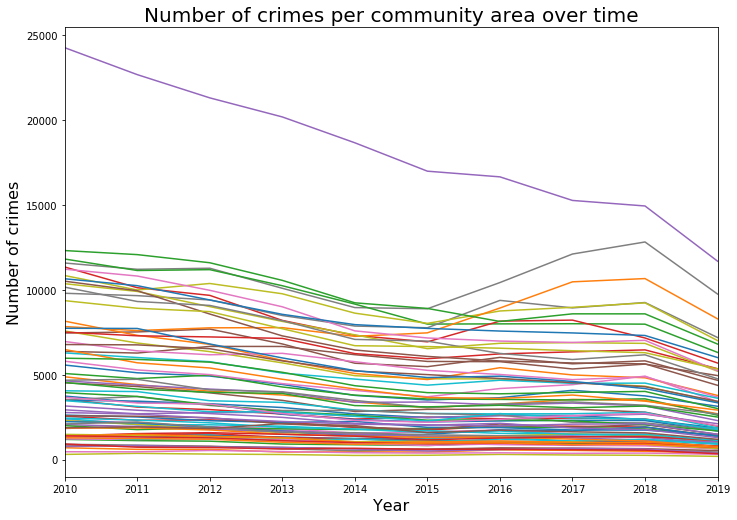

In [227]:
crimes_grouped.plot(legend=None)
plt.title('Number of crimes per community area over time', Fontsize = 20)
plt.ylabel('Number of crimes', Fontsize = 16)
plt.xlabel('Year', Fontsize = 16)
plt.show()

In [281]:
# take away the multi-indexing to facilitate manipulations on the data
density_grouped = crimes_grouped.Crimes.rename_axis([None], axis=1).reset_index()
density_grouped.set_index('Year', inplace=True)

# normalize the number of crimes by the surface area: nbr of crimes per squarekilometer
for area in density_grouped.columns:
    # area in squarekilometers
    surf = areas['surface'][area-1]/1000000
    density_grouped[area] = density_grouped[area]/surf

In [1]:
density_grouped.plot(legend=None)
plt.title('Number of crimes per community area over time', Fontsize = 20)
plt.ylabel('Number of crimes', Fontsize = 16)
plt.xlabel('Year', Fontsize = 16)
plt.show()

NameError: name 'density_grouped' is not defined

---

>**We will finalize our descriptive analysis until milestone 3 by also doing:**
>- Correlation analysis: Are there correlates between the food inspection fail rate of areas and online Yelp ratings of restaurants?
>- Concluding analysis:
    - Where can one safely eat delicious food in Chicago?
    - Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


## <span style='color:Gray'> Correlation analysis of hygienic standards and public safety

<span style='color:Gray'> Are there correlates between the food inspection fail rate of areas and public safety, measured through crime rates?

## <span style='color:Gray'> Concluding analysis

<span style='color:Gray'>
    
- Where can one safely eat delicious food in Chicago?
    
- Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


---

# <p style="color:#2e86c1"> Project pipeline

## Mid-term review

Working on three datasets simultaneously has proven to be quite a demanding and non-trivial task. The two datasets from the Chicago Data Portal required some data cleaning and wrangling to make it ready for our analyses but have proven to suit well our project needs. The Yelp reviews are extremely challenging to obtain and it has taken us several attempts before we managed to properly scrape the data. But we believe it is worth the effort as this will truly add a valuable element to our analysis. Our initial idea depicted in the README still fits with the current state of our project and we believe it is possible to attain our goals. In the next weeks, we will intensively work on performing correlation analyses among the three datasets to understand the underlying patterns. As an ultimate goal, we also aim to build some kind of recommender system that allows a tourist to get a tailored recommendation on where to eat deliciously, while staying safe in Chicago, based on their food preferences. 

## New internal milestones

We have updated the README with the following additional internal milestones:

**Due by Friday, Nov 29**

- Finish to scrap yelp and clean it
- Merge yelp dataset with CFI by adding info on reviews and cuisine type
- Do a more advanced correlation analysis of reviews and food inspections outcomes

**Due by Friday, Dec 06**

- Finish the analysis on food chains and cuisine types
- Perform correlation analysis of crimes and food inspections outcomes on the community area level
- Create all interactive plots for the data story
- Draft a plan for the data story


**Due by Friday, Dec 13**

- Wrap up the analysis and code a recommender system 
- Write the data story around the plots


**Due by Friday, Dec 20 - Project deadline**

- Finalize items to hand in: data story and final notebook 


**Due by Monday, Jan 20 - Poster presentation**

- Design a project poster
- Prepare the 3-minute presentation